In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(
                     noise_constraint=gpytorch.constraints.GreaterThan(0.0)
                ),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )
    
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star,
            f_post_samples.T.detach(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True);

def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()



# Maximum Mean - A Bad Information Acquisition Function

An naive information acquisition function is to select the arm with the highest mean. This is a bad idea. You should never do this. We will show why.

## Working 1D Example

It is easier to introduce the ideas using an example.
Let's work with a synthetic 1D function defined in $[0,1]$:

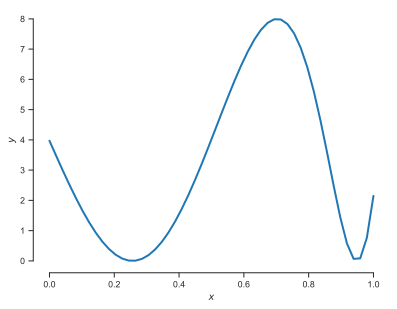

In [3]:
def f(x):
    """A function to optimize."""
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);

We wish to maximize this function.
Let us generate some starting data:

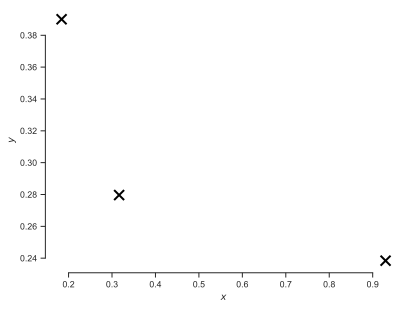

In [4]:
np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);

Assume we do some Bayesian regression using our data so far.
Here, we will do GPR, but any Bayesian regression would work.
We will not work right now with the full predictive $p(f(\cdot)|\mathcal{D}_{n})$, but with the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.

Here is an example with GPR:

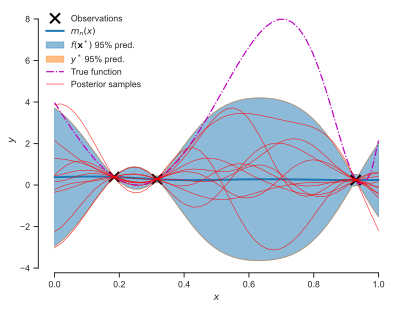

In [18]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
covar_module = ScaleKernel(RBFKernel())
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-6
model.eval()

plot_1d_regression(
    torch.from_numpy(x).float(),
    model,
    f_true=f
)

In [19]:
help(model.set_train_data)

Help on method set_train_data in module gpytorch.models.exact_gp:

set_train_data(inputs=None, targets=None, strict=True) method of __main__.ExactGP instance
    Set training data (does not re-fit model hyper-parameters).
    
    :param torch.Tensor inputs: The new training inputs.
    :param torch.Tensor targets: The new training targets.
    :param bool strict: (default True) If `True`, the new inputs and
        targets must have the same shape, dtype, and device
        as the current inputs and targets. Otherwise, any shape/dtype/device are allowed.



Now, the question is this: "Where should we evaluate the function next if our goal is to maximize the function?"
Let's start with the naive assumption that we should evaluate the function at the point that maximizes the Gaussian process posterior mean, i.e., wherever is the max of the thick blue line.
In other words, the information acquisition function is the posterior mean of the Gaussian process.
Let's see what happens.

In [65]:
def maximize_naive(f, model, X_design, max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    Arguments
    f        --  The function to optimize.
    model    --  A Gaussian process model to use for representing our state of knowledge.
    X_design --  The set of candidate points for identifying the maximum.
    max_it   --  The maximum number of iterations.
    """
    for count in range(max_it):
        model.train()
        model.eval()
        m = model(X_design).mean.detach()
        i = np.argmax(m)
        
        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)
        model.train()
        model.eval()
        
        fig, ax = plt.subplots()
        plot_1d_regression(
            X_design,
            model,
            ax=ax,
            f_true=f,
            num_samples=0
        )
        ax.plot(x[i], f(x[i]), 'go', label='Next observation')
        ax.set_title('BGO iteration #{0:d}'.format(count+1))
        plt.legend(loc='best', frameon=False)
        sns.despine(trim=True);

/opt/homebrew/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


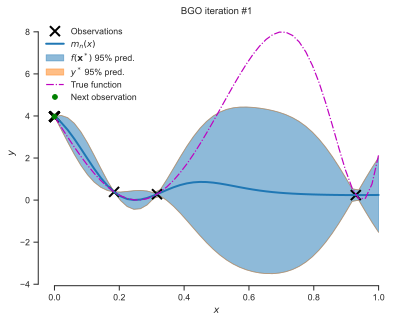

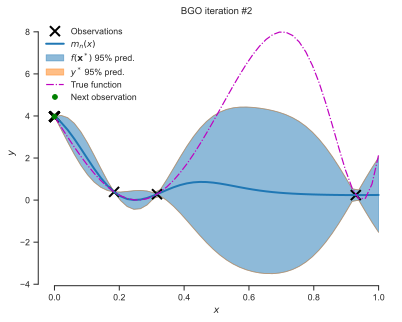

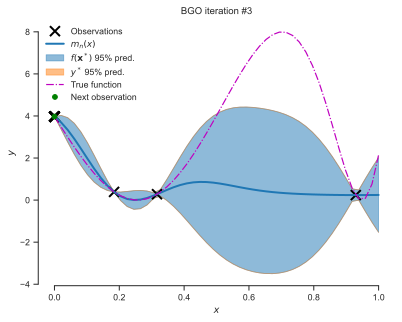

In [66]:
X_design = torch.from_numpy(x).float()
model.train()
maximize_naive(f, model, X_design, max_it=3)

Observe that the algorithm misses the actual maximum.
It gets trapped.
This is because using the posterior mean as an acquisition function focuses too much on **exploiting** the currently available information but fails to **explore** regions of the input space that we have yet to visit.

### Questions

+ Experiment with different numbers of initial observations. How many must you use for the algorithm to converge to the global maximum?